<a href="https://colab.research.google.com/github/sipocz/messer/blob/main/AIT4_Vizsgafeladat_20210422_Sipocz_Laszlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Feladat kiírás: Idősor elemzése**
Az ipari gyakorlatot az időben változó paraméterek jellemzik. Ezen paraméterek figyelése, elemzése pénzben is kifejezhető eredményt produkálhat. Egy ilyen feladat megoldására vállalkoznék az első javaslatomban:

Rendelkezésre áll egy ipari terület nitrogén fogyasztásával kapcsolatos adathalmaz. Az adatok egy Internetes felületről érhetők el. A megoldással kapcsolatos elvárások:
1. Az internetes felületről adatok letöltése (webscaping) technikával.
2. Az adatok feldolgozása, CSV-ben történő tárolása
3. Az adatok elemzése ahol a következő kérdésekre keressük a válaszokat:
    * Az adatok alapján jelezhetünk-e valamilyen kiugró értéket, 
valamilyen hibát, ami alapján emberi beavatkozási igény is felmerül.
    * Az adatok alapján történik-e valamilyen tendenciózus jelenség:
    * Emelkedő fogyasztás
    * Nem szokványos nyomás emelkedés, csökkenés ami a korábbi tapasztalatokból nem látszik. 
    * Lengés megjelenése a rendszerben
4. Felismerhető-e valamilyen összefüggés az adatokban, amivel az esetlegesen hiányzó adat  pótolható, becsülhető. (Soft Sensor)


# Importálás

In [21]:
!rm visual_view.py
!wget https://github.com/sipocz/messer/raw/main/visual_view.py | /dev/null

/bin/bash: /dev/null: Permission denied
--2021-04-12 16:39:11--  https://github.com/sipocz/messer/raw/main/visual_view.py
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sipocz/messer/main/visual_view.py [following]
--2021-04-12 16:39:11--  https://raw.githubusercontent.com/sipocz/messer/main/visual_view.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1010 [text/plain]
Saving to: ‘visual_view.py’

visual_view.py      100%[===================>]    1010  --.-KB/s    in 0s      

2021-04-12 16:39:11 (51.4 MB/s) - ‘visual_view.py’ saved [1010/1010]



In [22]:
from visual_view import grafikon
help(grafikon)

Help on function grafikon in module visual_view:

grafikon(fx, desc1, txt1, desc2='', txt2='', ngraf=2, c1='rgba(0,200,0,0.8)', c2='rgba(200,0,0,0.3)')
    grafikon(fx,desc1,txt1,desc2="",txt2="",ngraf=2,c1='rgba(0,200,0,0.8)', c2='rgba(200,0,0,0.3)')
    
    fx: dataFrame
    desc1:column1
    txt1: label1
    desc2:column2
    txt2: label2
    ngraf: number of graph
    c2: color1
    c2: color2



In [2]:
!pip install sktime

     |████████████████████████████████| 5.7MB 13.6MB/s 
     |████████████████████████████████| 22.3MB 2.0MB/s 
     |████████████████████████████████| 9.5MB 43.9MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


# Az adatok bemutatása

[Adatforrás](http://telemetry.messer.hu:8080/cgi-bin/rview.exe?Name=Richter1&Password=Messer2&Server=10.24.17.2&Language=hu)

[Egy nap adata: -04-04-](http://telemetry.messer.hu:8080/cgi-bin/rview.exe?Log=..%5C..%5Cppsrv%5CRichter1.txt&Html=Richter1log&MaxRows=15000&Year1=2021&Mon1=4&Day1=4&Hour1=0&Year2=2021&Mon2=4&Day2=4&Hour2=23)

Az adatok elérésehéz webscaping technikát használtam. A következő fejezet erről szól.

In [3]:
import requests
import pandas as pd
import time
import datetime

from bs4 import BeautifulSoup

def i2str(i):
    i2=str(i)
    if len(i2)<2:
        i2="0"+i2
    return(i2)

confline=   {
            "path":"./",
            "prefix":"Nitrogen"
            }

if "path" in confline:
    path=confline["path"]
if "prefix" in confline:
    prefix=confline["prefix"]

#print(path+prefix)

def getdata(t1,t2):
    #print(t1)
    #print(t2)
    y1=i2str(t1.year)
    m1=i2str(t1.month)
    d1=i2str(t1.day)


    y2=i2str(t2.year)
    m2=i2str(t2.month)
    d2=i2str(t2.day)

    url1="http://telemetry.messer.hu:8080/cgi-bin/rview.exe?Log=..%5C..%5C..%5Cppsrv%5CRichter1.txt&Html=Richter1log&MaxRows="
    url2="10000&Year1="+y1+"&Mon1="+m1+"&Day1="+d1+"&Hour1=0&Year2="+y2+"&Mon2="+m2+"&Day2="+d2+"&Hour2=0"

    url=url1+url2

    fname=path+prefix+y1+m1+d1+".csv"
    result=requests.get(url)
    soup = BeautifulSoup(result.content, 'html.parser')
    allrow=soup.find_all("tr")[:]
    fo  = open(fname, "w",encoding='utf-8')
    for  row in allrow:
        soup2=BeautifulSoup(result.content, 'html.parser')
        allcell=row.find_all("td")[:]
        sumcell=""
        #print("--------------")
        #print(allcell)
        for cell in allcell:
            celltxt=cell.text
            sumcell=sumcell+celltxt+";"

        outstr=sumcell.replace(".",",").replace(";"," ",1).replace(",",".",2).replace("   ","").replace("  ","")
        #print(outstr)

        fo.write(outstr+"\n")

    # Close file
    fo.close()
    return(fname)

In [4]:
t1=datetime.date.today() # !! ez a dátum a serveren értelmezett mai dátum 
print(t1)    #a mai nap
backtime=datetime.timedelta(days=1) # itt kezdi a letöltést ennyi nappal azelőtt nekünk most 1 nap kell a tegnapi nap megvan teljesen!
#egy napnyi adatot akarunk lekérdezni
tk=t1-backtime # a tegnapi nap lesz a kezdeti nap
dt=datetime.timedelta(days=1) # olyen időközökben kérünk új adatsort!

for i in range(1):  # ennyi napnyi adatot tölt le!! t1 -től kezdődően  Nekünk most csak egy kell! 
    t2=tk+dt
    fname=getdata(tk,t2)
    tk=t2


2021-04-12


**5 perces mintavétellel érkeznek az adatok**

In [145]:
import pandas as pd
df1=pd.read_csv(fname, sep=";", decimal=",",)
df1.drop(columns=["Unnamed: 6"],inplace = True)
print(df1[["Dátum Idõ","PSA mennyiség: [m3]"]].head(5))
print(df1[["Dátum Idõ","PSA mennyiség: [m3]"]].tail(5))

df1.describe()

             Dátum Idõ  PSA mennyiség: [m3]
0  2021.04.11 00:02:24                497.8
1  2021.04.11 00:07:24                421.9
2  2021.04.11 00:12:24                300.0
3  2021.04.11 00:17:24                  0.0
4  2021.04.11 00:22:24                494.1
               Dátum Idõ  PSA mennyiség: [m3]
283  2021.04.11 23:38:27                467.1
284  2021.04.11 23:43:28                363.1
285  2021.04.11 23:48:28                214.4
286  2021.04.11 23:53:28                518.7
287  2021.04.11 23:58:28                445.2


,LIN tartály menny.: [m3],LIN tartály nyomás: [barg],PSA mennyiség: [m3],PSA nyomás: [barg],PSA minőség: [%]
count,288.000000,288.000000,288.000000,288.000000,288.000000
mean,27595.187500,8.555417,356.412153,8.180556,0.156353
std,301.400227,0.238710,165.364032,0.347771,0.127866
min,27313.000000,8.320000,0.000000,7.300000,0.060800
25%,27359.000000,8.420000,286.175000,8.075000,0.081400
50%,27520.000000,8.470000,388.950000,8.300000,0.106150
75%,27612.000000,8.540000,483.250000,8.400000,0.177550
max,28222.000000,9.130000,727.700000,8.600000,0.806700


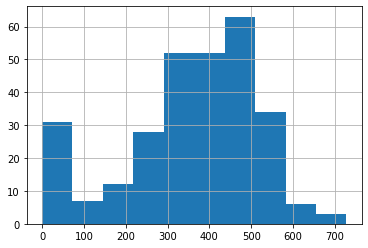

In [146]:
df1["PSA mennyiség: [m3]"].hist();

In [147]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
from sktime.utils.plotting import plot_series

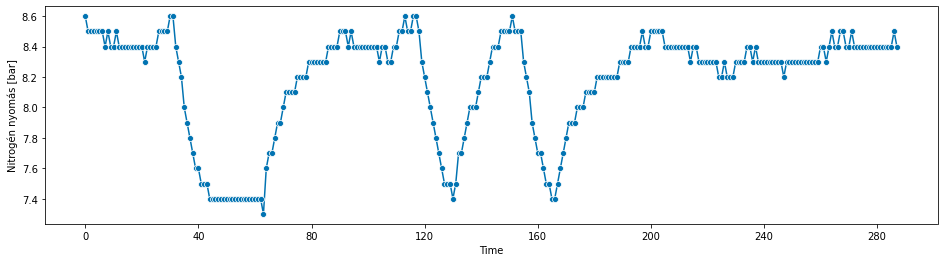

In [148]:
y = df1["PSA nyomás: [barg]"]

fig, ax = plot_series(y)
ax.set(xlabel="Time", ylabel="Nitrogén nyomás [bar]");

In [170]:
def grafikon(fx,desc1,txt1,desc2="",txt2="",ngraf=2,c1='rgba(35,128,132,0.8)', c2='rgba(200,0,0,0.3)',title=None):
    '''
    fx: dataFrame
    desc1:column1
    txt1: label1
    desc2:column2
    txt2: label2
    ngraf: number of graph
    c2: color1
    c2: color2
    '''
    
    #x_=[i for i in range(len(y_pred))]
    if title==None:
      title=txt1+txt2
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    fig0 = make_subplots(rows=1, cols=1)
    
    fig0.add_trace(
        go.Scatter(x=fx.index, y=fx[desc1], name=txt1, line=dict(color=c1) ,showlegend=True  ),

        row=1, col=1

    )
    
    if ngraf==2:
        fig0.add_trace(
            go.Scatter(x=fx.index, y=fx[desc2], name=txt2, line=dict(color=c2) ,showlegend=True  ),

            row=1, col=1
        )
    
    fig0.update_layout(
        title=title,
        autosize=False,
        width=1200,
        height=600,
        
        )

    fig0.show()

In [171]:
grafikon(df1,"PSA mennyiség: [m3]","PSA mennyiség [Nm3/h]",ngraf=1, title="Nitrogén fogyasztás adatok")

# Éves adathalmaz előállítása
A napi adatokat egy python script (mi más? :-) ) összefűzi egy teljes adatsorrá! A dátumformátumot is helyrerakja. Így később nem lesz vele dolgunk. A fejlécek értelmesebb (és rövidebb) elnevezést kapnak: 


---


[konverter program:](https://github.com/sipocz/messer/blob/b65c35a08bed9565d9df9ed6be1f1e94c53b004d/messer_convert.py)


## Adatok letöltése

Az adatok előfeldolgozása, előkészítése megtörtént. Az internetes elérés céljából github repoban vannak. 

In [172]:

!rm /content/all.csv
!wget "https://github.com/sipocz/messer/raw/main/all.csv"
!head /content/all.csv

--2021-04-12 19:49:36--  https://github.com/sipocz/messer/raw/main/all.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sipocz/messer/main/all.csv [following]
--2021-04-12 19:49:36--  https://raw.githubusercontent.com/sipocz/messer/main/all.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6240392 (6.0M) [text/plain]
Saving to: ‘all.csv’

all.csv             100%[===================>]   5.95M  --.-KB/s    in 0.09s   

2021-04-12 19:49:36 (63.3 MB/s) - ‘all.csv’ saved [6240392/6240392]

timeStamp,LIN_V,LIN_P,PSA_M,PSA_P,PSA_Q
2019-11-21 09:58:15,32356.38,9.0,626.1,7.6,0.2749
2019-11-21 10:03

In [174]:
# Az univerzalitás érdekében itt lehet konfigurálni, hogy hol található a működéshez szükséges fájl 

_PCVERSION_=False
_GITHUB_ORIG=True

if _PCVERSION_:
    basedir="C:/Users/sipocz/OneDrive/Dokumentumok/GitHub/nitrogen"
else:

    if _GITHUB_ORIG:
        basedir="/content/"
    else:
        from google.colab import drive
        drive.mount('/content/drive',force_remount=True)
        basedir="/content/drive/My Drive/001_AI/messer/nitrogen/"
print(f"Az alapkönyvtár: {basedir}")  


Az alapkönyvtár: /content/


## Olvassuk be az adathalmazt, vizsgáljuk!!

In [176]:
df=pd.read_csv(basedir+"all.csv")
print(df.head())
print("\n")
print(f"timeStamp adattípus: {type(df.timeStamp[0])}")


             timeStamp     LIN_V  LIN_P  PSA_M  PSA_P   PSA_Q
0  2019-11-21 09:58:15  32356.38   9.00  626.1    7.6  0.2749
1  2019-11-21 10:03:16  32346.85   9.00  663.1    7.7  0.2761
2  2019-11-21 10:03:21  32347.00   8.59  663.1    7.7  0.2761
3  2019-11-21 10:08:22  32350.00   8.61  548.9    7.7  0.2737
4  2019-11-21 10:13:21  32327.00   8.62  492.5    7.7  0.2694


timeStamp adattípus: <class 'str'>


## Az időbélyeget át kell konvertálni dátum formátumra! Ennek még később meglesz a haszna!

In [178]:
df["timeStamp"]=pd.to_datetime(df["timeStamp"],format="%Y.%m.%d %H:%M:%S")   # konvertáljuk az időbélyeget
df.set_index("timeStamp",inplace=True)

KeyError: ignored

## Ellenőrizzük vissza!

In [179]:
print(df.head())
print("\n")
print(f"timeStamp adattípus: {type(df.index[0])}")

                        LIN_V  LIN_P  PSA_M  PSA_P   PSA_Q
timeStamp                                                 
2019-11-21 09:58:15  32356.38   9.00  626.1    7.6  0.2749
2019-11-21 10:03:16  32346.85   9.00  663.1    7.7  0.2761
2019-11-21 10:03:21  32347.00   8.59  663.1    7.7  0.2761
2019-11-21 10:08:22  32350.00   8.61  548.9    7.7  0.2737
2019-11-21 10:13:21  32327.00   8.62  492.5    7.7  0.2694


timeStamp adattípus: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


## Nézzünk egy statisztikát az adatokról!

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122253 entries, 2019-11-21 09:58:15 to 2021-01-22 23:56:51
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   LIN_V   122253 non-null  float64
 1   LIN_P   122253 non-null  float64
 2   PSA_M   122253 non-null  float64
 3   PSA_P   122253 non-null  float64
 4   PSA_Q   122253 non-null  float64
dtypes: float64(5)
memory usage: 5.6 MB


In [181]:
print(f"{df.isnull().sum()} \ndarab  NAN van a DF-ben" )

LIN_V    0
LIN_P    0
PSA_M    0
PSA_P    0
PSA_Q    0
dtype: int64 
darab  NAN van a DF-ben


In [182]:
df.describe()

,LIN_V,LIN_P,PSA_M,PSA_P,PSA_Q
count,122253.000000,122253.000000,1.222530e+05,1.222530e+05,122253.000000
mean,28429.009433,8.821408,4.744283e+13,-2.539841e+14,0.264686
std,4026.864239,0.425946,8.456076e+15,1.549435e+15,0.273847
min,0.000000,0.000000,0.000000e+00,-9.707291e+15,0.000000
25%,25922.000000,8.580000,3.016000e+02,7.600000e+00,0.118100
50%,29177.000000,8.780000,4.727000e+02,7.900000e+00,0.186100
75%,31732.000000,9.000000,5.830000e+02,8.300000e+00,0.266900
max,34528.000000,11.260000,1.738199e+18,9.000000e+00,1.049100


##Vegyük észre !!
PSA_M max értéke és PSA_P min értéke nem reális adat! Valami hiba történt az adatgyűjtéssel?
Ne számoljunk ezekkel az értékekkel, ezeket meg kellene találni az adathalmazban és ki kellene gyomlálni!
Van-e az adatok között NaN?

***NAN nincs, akkor foglalkozzunk a kiugró értékekkel!***

In [183]:
index = df[df.PSA_M>1500].index
if len(index)!=0:
    print(f"Törlésre kerül {len(index)} darab kiugró érték!")
    df.drop(index, inplace=True)

index=df[df.PSA_M<0].index
print(f"Nullánál kisebb értékek száma: {len(index)} db.") 

Törlésre kerül 3199 darab kiugró érték!
Nullánál kisebb értékek száma: 0 db.


In [184]:
grafikon(df[:],"PSA_M",txt1="Nitrogén fogyasztás Nm3/h",ngraf=1)

In [185]:
df.describe()

,LIN_V,LIN_P,PSA_M,PSA_P,PSA_Q
count,119054.000000,119054.000000,119054.000000,119054.000000,119054.000000
mean,28418.873127,8.826726,421.759058,7.942916,0.265087
std,4046.101379,0.428086,217.713274,0.417539,0.277101
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25893.000000,8.580000,292.100000,7.600000,0.116800
50%,29160.000000,8.780000,466.800000,7.900000,0.184800
75%,31737.000000,9.010000,574.600000,8.300000,0.262800
max,34528.000000,11.260000,1216.000000,9.000000,1.049100


# Statisztikai elemzés
Sikerült megtisztítani az adathalmazt. Nézzünk néhány statisztikát!


## ADF 


adfuller leírás: [__itt__](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html)

Kritikus értékek leírása: [__itt__](https://www.econ.queensu.ca/sites/econ.queensu.ca/files/wpaper/qed_wp_1227.pdf)


In [191]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' {} ellenőrzése'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC',regression="ct") # ct: lineáris trend van -e az adatfolyamban
    print(dftest)
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))
    print("--------------------------------------------")

In [192]:
ADF_test(df.PSA_Q,'PSA minőség')
ADF_test(df.PSA_M,'PSA tömegáram')
ADF_test(df.PSA_P,'PSA nyomás ')

 PSA minőség ellenőrzése
(-6.606585171018406, 1.0741707077636441e-07, 66, 118987, {'1%': -3.9588460867903748, '5%': -3.410526898786794, '10%': -3.1270717303822133}, -530129.5415723646)
Test statistic = -6.607
P-value = 0.000
Critical values :
	1%: -3.9588460867903748 - The data is  stationary with 99% confidence
	5%: -3.410526898786794 - The data is  stationary with 95% confidence
	10%: -3.1270717303822133 - The data is  stationary with 90% confidence
--------------------------------------------
 PSA tömegáram ellenőrzése
(-8.48879525667423, 5.323391067924124e-12, 71, 118982, {'1%': -3.958846089987867, '5%': -3.4105269003374246, '10%': -3.127071731295404}, 1373455.8763946837)
Test statistic = -8.489
P-value = 0.000
Critical values :
	1%: -3.958846089987867 - The data is  stationary with 99% confidence
	5%: -3.4105269003374246 - The data is  stationary with 95% confidence
	10%: -3.127071731295404 - The data is  stationary with 90% confidence
--------------------------------------------


Kijelenthetjük, amiben reménykedtünk is, hogy az adatainkben nem jelentkezik trend. Statikus a rendszerünk. Ez jó, mert nem szeretnénk egyre több pénzt költeni nitrogénre!! :-)

## Scatter_matrix

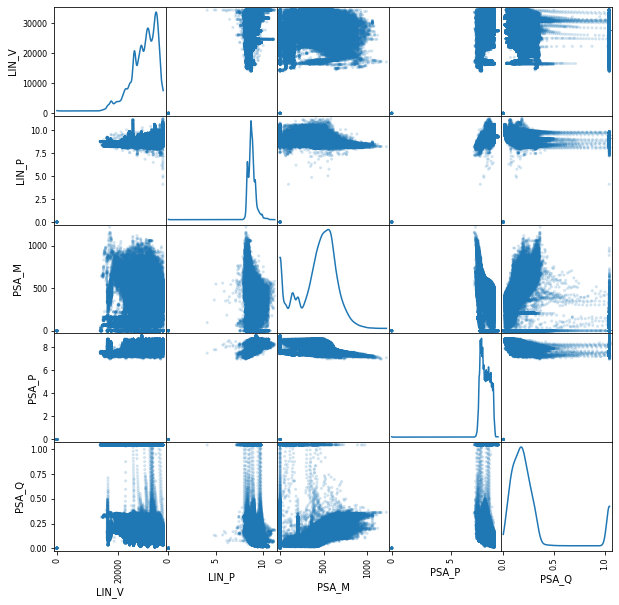

In [187]:
# Készítsünk egy scatter plotot!
from pandas.plotting import scatter_matrix

scatter_matrix(df, alpha = 0.2, figsize = (10, 10), diagonal = 'kde');

# ÖTLET: Hétvégi fogyasztásokat meg kellene nézni!!!